In [1]:
"""This notebook shows a python analysis using geopandas, pandas, and matplotlib to try to detemine patterns in the data from 
the Austin Resource Recovery smart fleet web API. 

With over 200 individual routes and vehicles, six route types (recycling, trash, organics, etc.) and a multitude of variables 
affecting operational efficiency, ARR hopes to utilize the new technology to improve the city. 
The data retrieved from this breadcrumb API is recorded by the trucks daily and includes information such as heading,
speed, location, route, and time, updated every ~30 seconds. By exploring this data with open source tools we hope to
quantify and extract patterns in route balancing."""

'This notebook shows a python analysis using geopandas, pandas, and matplotlib to try to detemine patterns in the data from \nthe Austin Resource Recovery smart fleet web API. \n\nWith over 200 individual routes and vehicles, six route types (recycling, trash, organics, etc.) and a multitude of variables \naffecting operational efficiency, ARR hopes to utilize the new technology to improve the city. \nThe data retrieved from this breadcrumb API is recorded by the trucks daily and includes information such as heading,\nspeed, location, route, and time, updated every ~30 seconds. By exploring this data with open source tools we hope to\nquantify and extract patterns in route balancing.'

In [2]:
import requests
import json
import numpy as np
import os

from shapely.geometry import Point
import geopandas as gpd

import pandas as pd

from scipy import ndimage

import datetime
from datetime import date, timedelta

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Return breadcrumbs for all vehicles
data = {"vehicleName": "All"}
headers = {'X-ApiKey' : os.environ['API_KEY']}

In [4]:
# Since the endpoint requires the day to be specified in the URL, lets create a list of dates for querying. 
# Approximately 4 months of data will be returned.

dates = []
dataframes = []
now = datetime.datetime.now()
today = now.strftime("%Y-%m-%d")

d1 = '2019-01-01'
d2 = '2019-05-08'
date1 = date(int(d1.split('-')[0]), int(d1.split('-')[1]), int(d1.split('-')[-1]))
date2 = date(int(d2.split('-')[0]), int(d2.split('-')[1]), int(d2.split('-')[-1]))
delta = date2 - date1
for i in range(delta.days):
    dates.append(str(date1 + timedelta(i)))

In [5]:
for day in dates:
    payload = { "startDate": "{}".format(day),
                "endDate": "{}".format(day),
                "vehicleName": "",
                "routeName": ""}

    url = os.environ['BREADCRUMB_ENDPOINT']
    # Make web request
    r = requests.post(url, data=payload, headers=headers)
    result = json.loads(r.content)
    df = pd.DataFrame(result['Data'])
    # Prep lat/lon for geospatial conversion
    df = df.astype({"lat": float, "lon": float})
    df['Coordinates'] = list(zip(df.lon, df.lat))
    df['Coordinates'] = df['Coordinates'].apply(Point)
    
    # Time calculations:
    # Convert timestamp to datetime object
    d = int(day.split('-')[-1])
    y = int(day.split('-')[0])
    m = int(day.split('-')[1])
    df['timeStamp'] =  pd.to_datetime(df['timeStamp'], format="%Y-%m-%dT%H:%M:%S")
    # Calculate day of week
    df['day'] = df['timeStamp'].dt.weekday_name
    # Filter out times & days that we dont need (Saturday and Sunday, 10pm-4am)
    df = df.loc[(df['timeStamp'] > datetime.datetime(y, m, d, 4, 0, 0)) # filter before 4am
              & (df['timeStamp'] < datetime.datetime(y, m, d, 22, 0, 0)) # filter after 10pm
              & (df['day'] != 'Sunday') & (df['day'] != 'Saturday')] # filter sunday and saturday
    
    # Convert to geopandas geodataframe
    gdf = gpd.GeoDataFrame(df, geometry='Coordinates', crs="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    # Join truck type data
    truck_df = pd.read_csv('test.csv')
    gdf = gdf.join(truck_df.set_index('Vehicle Number'), on='vehicleName')
    
    dataframes.append(gdf)

In [10]:
# Here is what the data looks like from the API after joining and creating geometry with geopandas:
dataframes[0].sample(10)

,direction,lat,lon,routeName,speed,timeStamp,vehicleName,weight,weightUnit,Coordinates,day,Make,Current Modem Serial No.,Division,Unit Type
5477,0,30.254442,-97.700552,,,2019-01-01 16:07:44,17G951,,None,POINT (-97.700552 30.2544425),Tuesday,NaN,NaN,NaN,NaN
4635,0,30.267622,-97.673420,,,2019-01-01 13:38:42,13G464,,None,POINT (-97.67341999999999 30.2676218),Tuesday,AUTOCAR,CA10493081410,Collection Services/Garbage,Automated
4028,0,30.212734,-97.738324,,,2019-01-01 11:51:43,13G792,,None,POINT (-97.7383237 30.2127337),Tuesday,CRANE CARR,CA13222036910,Yard Trimmings,Rear Loader/CC-Multipak
5767,0,30.212782,-97.738288,,,2019-01-01 16:59:00,13G792,,None,POINT (-97.7382882 30.2127817),Tuesday,CRANE CARR,CA13222036910,Yard Trimmings,Rear Loader/CC-Multipak
4019,0,30.212770,-97.738318,,,2019-01-01 11:50:09,13G792,,None,POINT (-97.73831800000001 30.2127702),Tuesday,CRANE CARR,CA13222036910,Yard Trimmings,Rear Loader/CC-Multipak
5573,0,30.254445,-97.700490,,,2019-01-01 16:24:34,17G951,,None,POINT (-97.7004902 30.2544455),Tuesday,NaN,NaN,NaN,NaN
7139,0,30.212764,-97.738349,,,2019-01-01 21:00:08,13G792,,None,POINT (-97.7383495 30.2127637),Tuesday,CRANE CARR,CA13222036910,Yard Trimmings,Rear Loader/CC-Multipak
5570,0,30.254430,-97.700489,,,2019-01-01 16:24:02,17G951,,None,POINT (-97.7004888 30.2544298),Tuesday,NaN,NaN,NaN,NaN
6451,0,30.254364,-97.700290,,,2019-01-01 18:59:19,17G951,,None,POINT (-97.70029049999999 30.2543638),Tuesday,NaN,NaN,NaN,NaN
6639,0,30.267632,-97.673408,,,2019-01-01 19:32:18,13G464,,None,POINT (-97.6734077 30.267632),Tuesday,AUTOCAR,CA10493081410,Collection Services/Garbage,Automated


In [545]:
# We need to remove unecessary data to lower processing times and imrprove results:
# Concatenate list of geodataframes into single
gdf_combined = pd.concat(dataframes)

# Load geometries for clipping the general area, north yard, and south yard.
poly = gpd.read_file('clip.geojson')
yardn = gpd.read_file('yard_clip_north.geojson')
yards = gpd.read_file('yard_clip_south.geojson')

# clip general area
gdf_combined = gpd.sjoin(gdf_combined, poly, how='inner')

# exclude yards using geopandas difference 
# south yard
yards_mask = gdf_combined.difference(yards.loc[0, 'geometry'])
gdf_combined['Coordinates'] = yards_mask
gdf_combined = gdf_combined[gdf_combined['Coordinates'].notnull()]
# north yard
yardn_mask = gdf_combined.difference(yardn.loc[0, 'geometry'])
gdf_combined['Coordinates'] = yardn_mask
gdf_combined = gdf_combined[gdf_combined['Coordinates'].notnull()]

C:\Users\MontgomeryT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


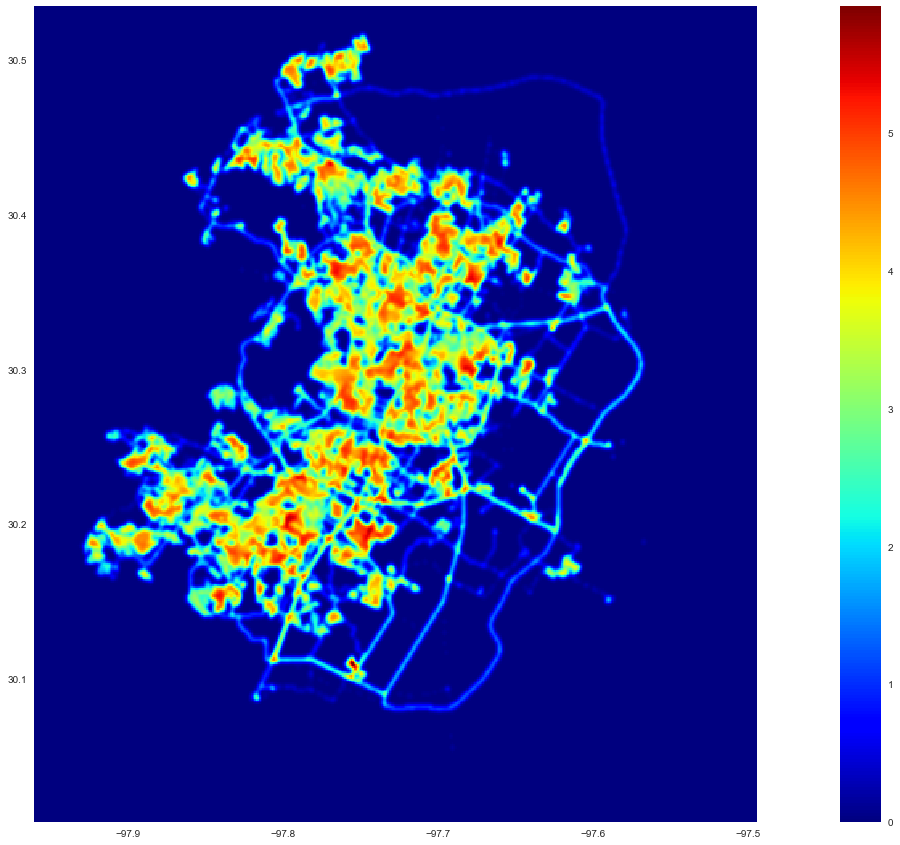

In [736]:
# We're not really doing GIS until there is an unecessary heatmap:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    plt.figure(figsize=(30,15))
    plt.grid(False)
    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()
    
heatmap(gdf_combined['Coordinates'], bins=450, smoothing=1.25 )

In [ ]:
# Lets calculate average route durations to quantify route balancing.

In [720]:
routes = gdf_combined['routeName'].unique()

route_gdfs = {}
for route in routes[1:]:
    route_gdf = gdf_combined.loc[gdf_combined['routeName'] == route]
    route_gdf.sort_values('timeStamp', inplace=True)
    route_gdf.insert(0, 'SeqID', range(0, len(route_gdf)))
    route_gdfs[route] = route_gdf

# Calculate average time to complete each route
route_times = pd.DataFrame(columns=['Route', 'Average Duration',
                                    'Latest End', 'Earliest Start',
                                    'Minimum Duration', 'Maximum Duration', 'Records'])
for route in route_gdfs:   
    # Filter routes that have less than 3 days records
    records = (len((route_gdfs[route]['timeStamp'].dt.floor('d').value_counts())))
    if records < 3:
        continue
        
    # Find earliest start and latest end
    route_gdfs[route]['date'] = route_gdfs[route]['timeStamp'].dt.floor('d')
    max_dates = route_gdfs[route].groupby(route_gdfs[route]['date']).max().timeStamp
    min_dates = route_gdfs[route].groupby(route_gdfs[route]['date']).min().timeStamp   
    # Find longest and shortest route durations
    min_duration = (max_dates - min_dates).min()
    max_duration = (max_dates - min_dates).max()
    min_start = (route_gdfs[route]['timeStamp'].min())
    max_end = (route_gdfs[route]['timeStamp'].max())   
    # Find average route duration
    average_duration = ((max_dates - min_dates).mean())
    
    route_times = route_times.append({'Route': route,
                                      'Average Duration': average_duration,
                                      'Latest End': max_end,
                                      'Earliest Start': min_start,
                                      'Maximum Duration': max_duration,
                                      'Minimum Duration': min_duration,
                                      'Records': records}, ignore_index=True)

route_times.set_index('Route', inplace=True)


C:\Users\MontgomeryT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\MontgomeryT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [795]:
route_times = route_times.sort_values('Average Duration')
route_times['Average Duration'] = route_times['Average Duration'].astype('timedelta64[m]')

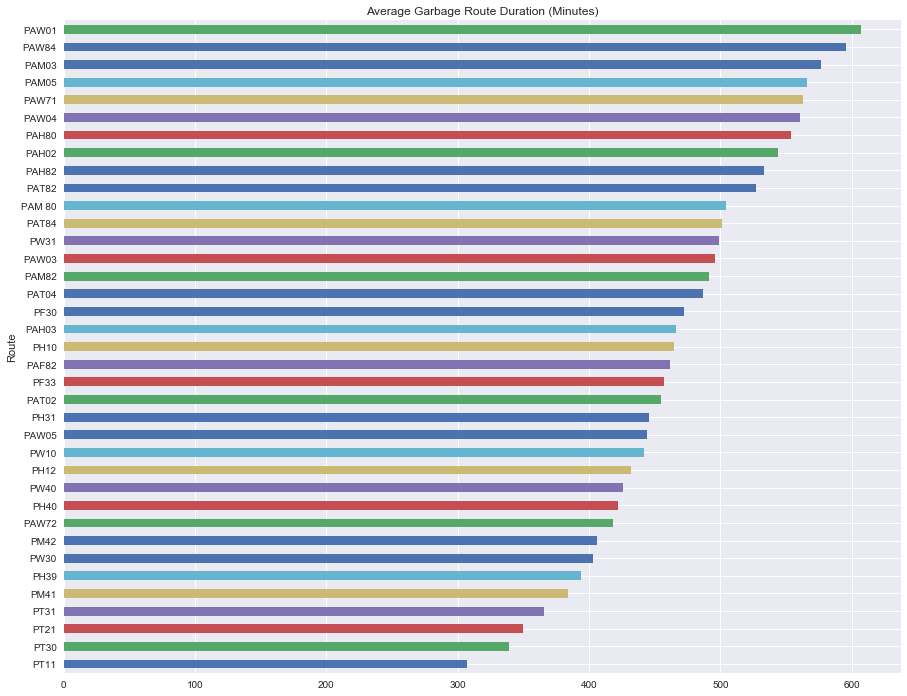

In [796]:
# Bar chart of garbage route average durations. Only showing half for aesthetics.
garbage = route_times.loc[route_times.index.str.startswith('P', na=False)]
ax = garbage['Average Duration'].iloc[1::2].plot(kind='barh',figsize=(15,12), title ="Average Garbage Route Duration (Minutes)")
plt.show()

Text(0,1,'Average Length (Minutes) For Garbage Route Completion')

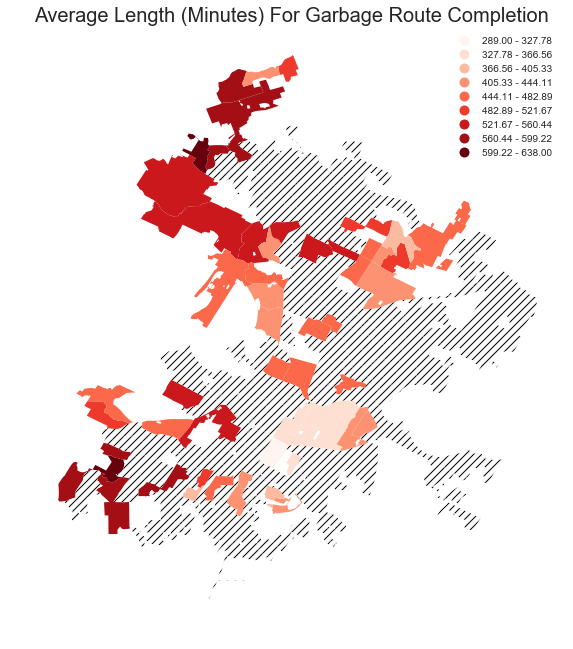

In [797]:
# Chloropleth mapping of duration using geopandas:
merged_g = payt.merge(garbage, left_on='ROUTE_NAME', right_on=garbage.index.values)
ax = merged.plot('Average Duration', cmap='Reds', figsize=(17, 11), scheme='equal_interval', k=9, legend=True)
payt[~payt['ROUTE_NAME'].isin(garbage.index.values)].plot(ax=ax, color='#fafafa', hatch='///')
ax.set_axis_off()
ax.set_title('Average Length (Minutes) For Garbage Route Completion', fontdict={'fontsize': 20}, loc='left')

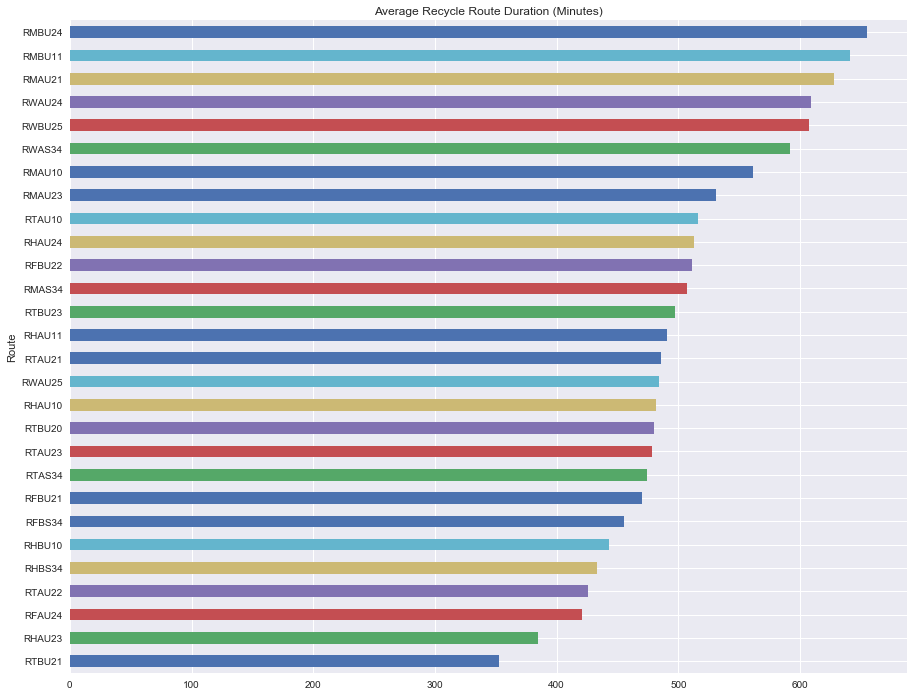

In [798]:
# Bar chart of recycle route average durations. Only showing half for aesthetics.
recycle = route_times.loc[route_times.index.str.startswith('R', na=False)]
ax = recycle['Average Duration'].iloc[1::2].plot(kind='barh',figsize=(15,12), title ="Average Recycle Route Duration (Minutes)")
plt.show()

Text(0,1,'Average Length (Minutes) For Recycle Route Completion')

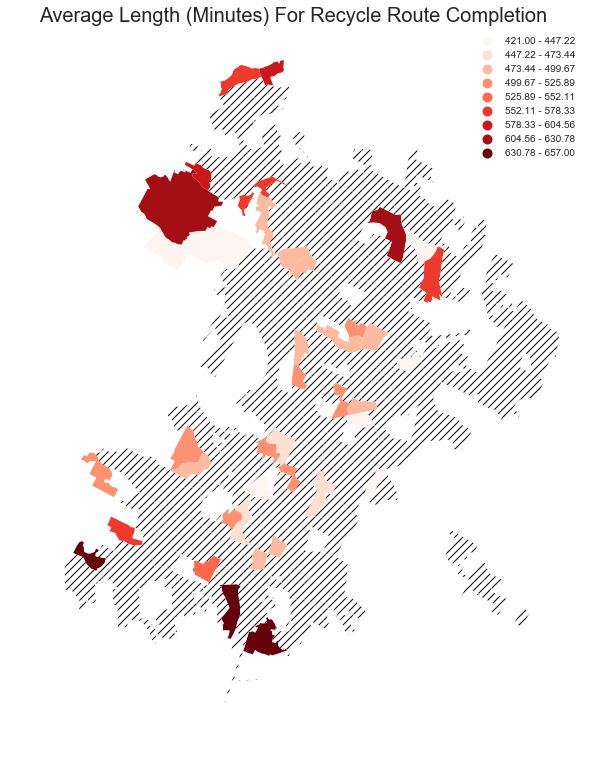

In [799]:
ax = merged_r.plot('Average Duration', cmap='Reds', figsize=(14, 13), scheme='equal_interval', k=9, legend=True)
recycle_gpd[~recycle_gpd['REC_RT'].isin(recycle.index.values)].plot(ax=ax, color='#fafafa', hatch='///')
ax.set_axis_off()
ax.set_title('Average Length (Minutes) For Recycle Route Completion', fontdict={'fontsize': 20}, loc='left')